## Welcome to the `Segformer` Workshop!
In this workshop, we'll learn the concept of how to use Segformer (involving Transformers, Feedforward networks and MLP decoders) for Semantic Segmentation Network models using Pytorch. We'll do the following tasks:

- Dataset : Download and use BDD100k dataset
- Network : Define a Segformer MiT B3 model with Mix Transformer encoder and MLP decoder
- Training : Train and validate model on the custom dataset
- Evaluate : Evaluate the model on Test Data and visualize results

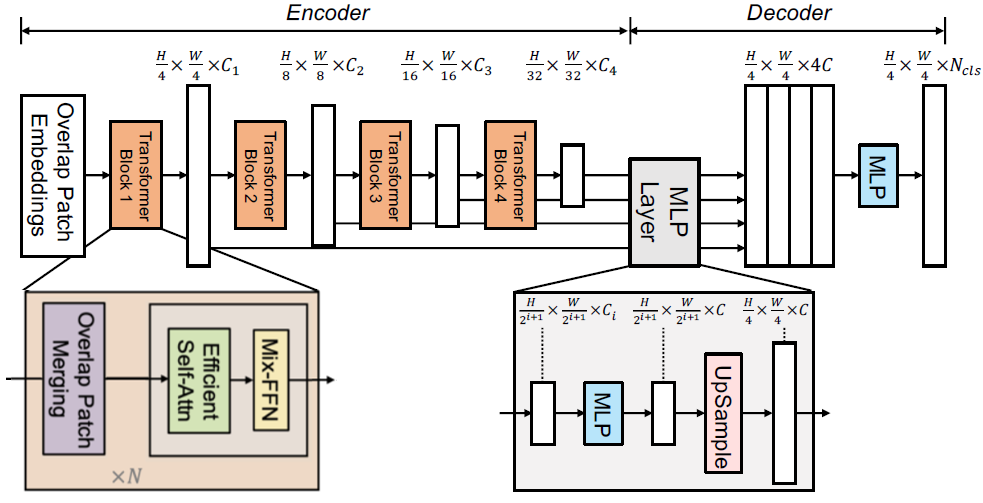

[Image reference](https://arxiv.org/abs/2105.15203)

## Basic Imports

In [1]:
# !wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/segformers.zip && unzip segformers.zip
# !mv segformers/* .

We have a few conflicting files, so make sure you download segmentation **after** segformers, so we have the right utils.py file.

Notice some of our weights are already trained for drivable area: **Segformers MIT B2**, and **Segformers MIT B3**

In [2]:
try:
    from einops import rearrange
    import segmentation_models_pytorch as smp
    from timm.models.layers import drop_path, trunc_normal_

except:
    !pip install timm
    !pip install einops
    !pip install segmentation-models-pytorch

    from einops import rearrange
    import segmentation_models_pytorch as smp
    from timm.models.layers import drop_path, trunc_normal_

/home/yacine/miniconda3/envs/3dvision/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
# basic imports
import numpy as np

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# libraries for loading image, plotting
import cv2
import matplotlib.pyplot as plt

## 1. Dataset: The BDD100k dataset

In [4]:
output_path = 'dataset'

images = np.load("dataset/image_180_320.npy")
labels = np.load("dataset/label_180_320.npy")

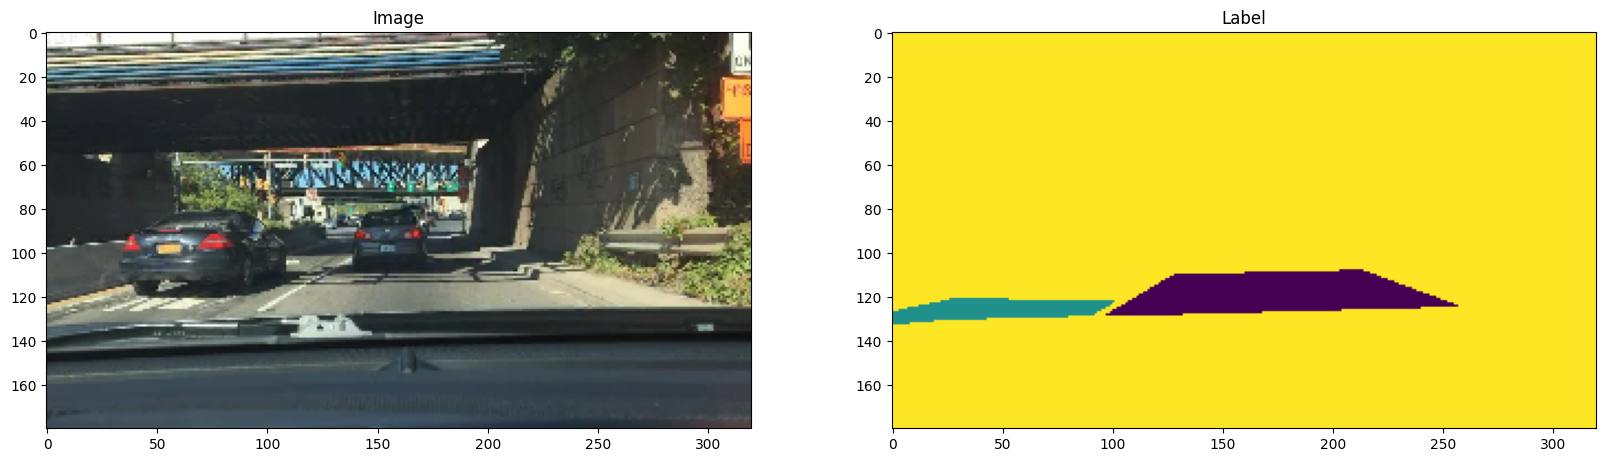

In [5]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,40))
idx=316
ax0.imshow(images[idx])
ax0.set_title("Image")
ax1.imshow(labels[idx])
ax1.set_title("Label")
plt.show()

### Build Datasets & DataLoaders
Every PyTorch model is built and train using 3 elements:

*   Dataset
*   DataLoader
*   Model


In [6]:
# utility functions to get BDD100k Pytorch dataset and dataloaders
from utils import get_datasets, get_dataloaders

train_set, val_set, test_set= get_datasets(images, labels)
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


## Show Sample images from dataset

In [7]:
from collections import namedtuple

# Each label is a tuple with name, class id and color
Label = namedtuple( "Label", [ "name", "train_id", "color"])
drivables = [
             Label("direct", 0, (215, 40, 135)),        # red
             Label("alternative", 1, (61, 143, 86)),  # cyan
             Label("background", 2, (0, 0, 0)),        # black
            ]

train_id_to_color = [c.color for c in drivables if (c.train_id != -1 and c.train_id != 255)]
train_id_to_color = np.array(train_id_to_color)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10399997..1.0].


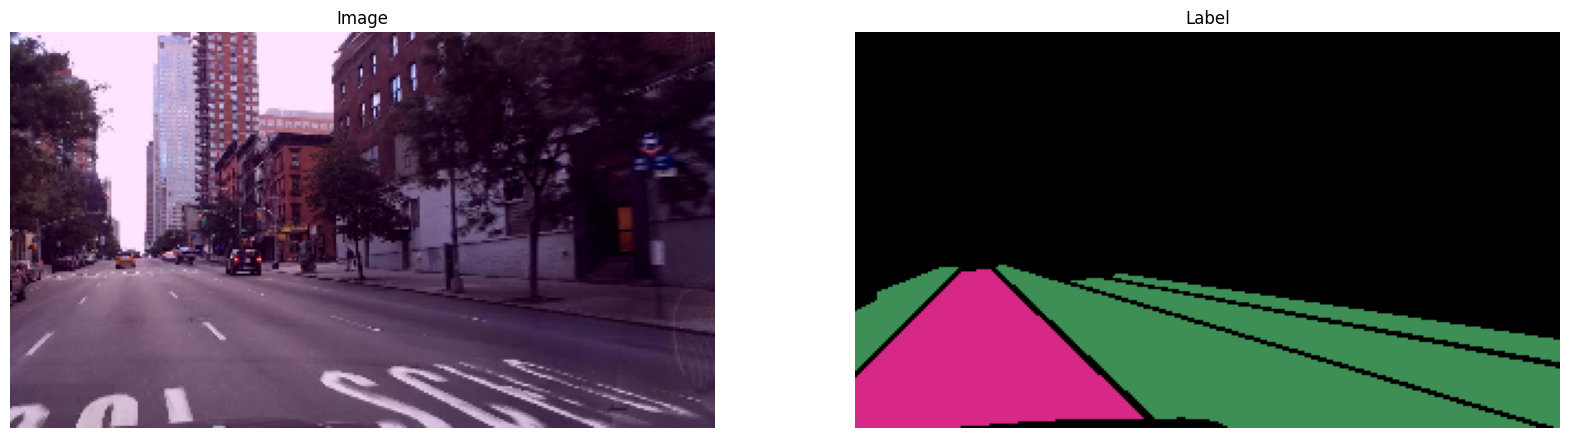

In [8]:
from utils import inverse_transform

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

# Network : Define a Segformer MiT B3 model with Mix Transformer encoder and MLP decoder


### Overlap Patch Embedding

In [9]:
class overlap_patch_embed(nn.Module):
    def __init__(self, patch_size, stride, in_chans, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size // 2, patch_size // 2))
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x)
        _, _, h, w = x.shape
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.norm(x)
        return x, h, w

### Mix Feed Forward Network

In [10]:
class mix_feedforward(nn.Module):
    def __init__(self, in_features, out_features, hidden_features, dropout_p = 0.0):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)

        # Depth-wise separable convolution
        self.conv = nn.Conv2d(hidden_features, hidden_features, (3, 3), padding=(1, 1),
                              bias=True, groups=hidden_features)
        self.dropout_p = dropout_p

    def forward(self, x, h, w):
        x = self.fc1(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        x = self.conv(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = F.gelu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        return x


### Efficient Self Attention

In [11]:
class efficient_self_attention(nn.Module):
    def __init__(self, attn_dim, num_heads, dropout_p, sr_ratio):
        super().__init__()
        assert attn_dim % num_heads == 0, f'expected attn_dim {attn_dim} to be a multiple of num_heads {num_heads}'
        self.attn_dim = attn_dim
        self.num_heads = num_heads
        self.dropout_p = dropout_p
        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(attn_dim, attn_dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(attn_dim)

        # Multi-head Self-Attention using dot product
        # Query - Key Dot product is scaled by root of head_dim
        self.q = nn.Linear(attn_dim, attn_dim, bias=True)
        self.kv = nn.Linear(attn_dim, attn_dim * 2, bias=True)
        self.scale = (attn_dim // num_heads) ** -0.5

        # Projecting concatenated outputs from
        # multiple heads to single `attn_dim` size
        self.proj = nn.Linear(attn_dim, attn_dim)


    def forward(self, x, h, w):
        q = self.q(x)
        q = rearrange(q, ('b hw (m c) -> b m hw c'), m=self.num_heads)

        if self.sr_ratio > 1:
            x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
            x = self.sr(x)
            x = rearrange(x, 'b c h w -> b (h w) c')
            x = self.norm(x)

        x = self.kv(x)
        x = rearrange(x, 'b d (a m c) -> a b m d c', a=2, m=self.num_heads)
        k, v = x[0], x[1] # x.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = attn @ v
        x = rearrange(x, 'b m hw c -> b hw (m c)')
        x = self.proj(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        return x

### Mix Transformer

In [12]:
class transformer_block(nn.Module):
    def __init__(self, dim, num_heads, dropout_p, drop_path_p, sr_ratio):
        super().__init__()
        # One transformer block is defined as :
        # Norm -> self-attention -> Norm -> FeedForward
        # skip-connections are added after attention and FF layers
        self.attn = efficient_self_attention(attn_dim=dim, num_heads=num_heads,
                    dropout_p=dropout_p, sr_ratio=sr_ratio)
        self.ffn = mix_feedforward( dim, dim, hidden_features=dim * 4, dropout_p=dropout_p)

        self.drop_path_p = drop_path_p
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)


    def forward(self, x, h, w):
        # Norm -> self-attention
        skip = x
        x = self.norm1(x)
        x = self.attn(x, h, w)
        x = drop_path(x, drop_prob=self.drop_path_p, training=self.training)
        x = x + skip

        # Norm -> FeedForward
        skip = x
        x = self.norm2(x)
        x = self.ffn(x, h, w)
        x = drop_path(x, drop_prob=self.drop_path_p, training=self.training)
        x = x + skip
        return x

In [13]:
class mix_transformer_stage(nn.Module):
    def __init__(self, patch_embed, blocks, norm):
        super().__init__()
        self.patch_embed = patch_embed
        self.blocks = nn.ModuleList(blocks)
        self.norm = norm

    def forward(self, x):
        x, h, w = self.patch_embed(x)
        for block in self.blocks:
            x = block(x, h, w)
        x = self.norm(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        return x

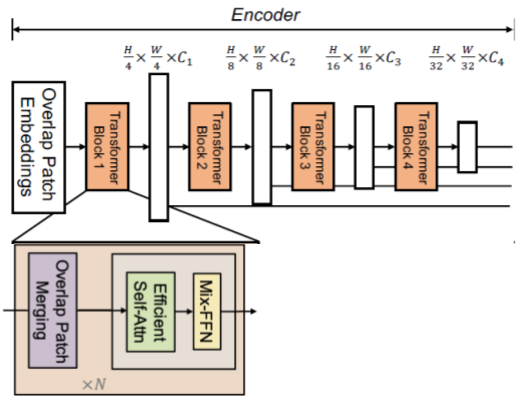

[Image reference](https://arxiv.org/abs/2105.15203)

In [14]:
class mix_transformer(nn.Module):
    def __init__(self, in_chans, embed_dims, num_heads, depths,
                sr_ratios, dropout_p, drop_path_p):
        super().__init__()
        self.stages = nn.ModuleList()
        for stage_i in range(len(depths)):
            # Each Stage consists of following blocks :
            # Overlap patch embedding -> mix_transformer_block -> norm
            blocks = []
            for i in range(depths[stage_i]):
                blocks.append(transformer_block(dim = embed_dims[stage_i],
                        num_heads= num_heads[stage_i], dropout_p=dropout_p,
                        drop_path_p = drop_path_p * (sum(depths[:stage_i])+i) / (sum(depths)-1),
                        sr_ratio = sr_ratios[stage_i] ))

            if(stage_i == 0):
                patch_size = 7
                stride = 4
                in_chans = in_chans
            else:
                patch_size = 3
                stride = 2
                in_chans = embed_dims[stage_i -1]

            patch_embed = overlap_patch_embed(patch_size, stride=stride, in_chans=in_chans,
                            embed_dim= embed_dims[stage_i])
            norm = nn.LayerNorm(embed_dims[stage_i], eps=1e-6)
            self.stages.append(mix_transformer_stage(patch_embed, blocks, norm))


    def forward(self, x):
        outputs = []
        for stage in self.stages:
            x = stage(x)
            outputs.append(x)
        return outputs

### Segformer Head / Decoder

In [15]:
class segformer_head(nn.Module):
    def __init__(self, in_channels, num_classes, embed_dim, dropout_p=0.1):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.dropout_p = dropout_p

        # 1x1 conv to fuse multi-scale output from encoder
        self.layers = nn.ModuleList([nn.Conv2d(chans, embed_dim, (1, 1))
                                     for chans in reversed(in_channels)])
        self.linear_fuse = nn.Conv2d(embed_dim * len(self.layers), embed_dim, (1, 1), bias=False)
        self.bn = nn.BatchNorm2d(embed_dim, eps=1e-5)

        # 1x1 conv to get num_class channel predictions
        self.linear_pred = nn.Conv2d(self.embed_dim, num_classes, kernel_size=(1, 1))
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.linear_fuse.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x):
        feature_size = x[0].shape[2:]

        # project each encoder stage output to H/4, W/4
        x = [layer(xi) for layer, xi in zip(self.layers, reversed(x))]
        x = [F.interpolate(xi, size=feature_size, mode='bilinear', align_corners=False)
             for xi in x[:-1]] + [x[-1]]

        # concatenate project output and use 1x1
        # convs to get num_class channel output
        x = self.linear_fuse(torch.cat(x, dim=1))
        x = self.bn(x)
        x = F.relu(x, inplace=True)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.linear_pred(x)
        return x

In [16]:
class segformer_mit_b3(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Encoder block
        self.backbone = mix_transformer(in_chans=in_channels, embed_dims=(64, 128, 320, 512),
                                    num_heads=(1, 2, 5, 8), depths=(3, 4, 18, 3),
                                    sr_ratios=(8, 4, 2, 1), dropout_p=0.0, drop_path_p=0.1)
        # decoder block
        self.decoder_head = segformer_head(in_channels=(64, 128, 320, 512),
                                    num_classes=num_classes, embed_dim=256)

    def forward(self, x):
        image_hw = x.shape[2:]
        x = self.backbone(x)
        x = self.decoder_head(x)
        x = F.interpolate(x, size=image_hw, mode='bilinear', align_corners=False)
        return x

## 3. Training : Train and validate model on the custom dataset


We will reuse the utility functions we defined in UNet notebook

In [17]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

## Model Training

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MODEL HYPERPARAMETERS
N_EPOCHS = 35
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'segformer_mit_b3'

import os
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
criterion = smp.losses.DiceLoss('multiclass', classes=[0,1,2], log_loss = True, smooth=1.0)

# create model, load imagenet pretrained weights
model = segformer_mit_b3(in_channels=3, num_classes=NUM_CLASSES).to(device)
backbone_weights = torch.load(os.path.join("weights", *['segformer_mit_b3_imagenet_weights.pt']))
model.backbone.load_state_dict(backbone_weights)

<All keys matched successfully>

Starting 1 epoch ...


  0%|          | 0/300 [00:00<?, ?it/s]Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.0
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
100%|██████████| 86/86 [00:06<00:00, 12.88it/s]


Epoch: 1, trainLoss:0.74175, validationLoss:0.49851, meanIoU: 0.59
Starting 2 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.39it/s]


Epoch: 2, trainLoss:0.36877, validationLoss:0.31419, meanIoU: 0.69
Starting 3 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.58it/s]


Epoch: 3, trainLoss:0.23843, validationLoss:0.26370, meanIoU: 0.72
Starting 4 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.30it/s]


Epoch: 4, trainLoss:0.19080, validationLoss:0.28903, meanIoU: 0.71
Starting 5 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.26it/s]


Epoch: 5, trainLoss:0.17168, validationLoss:0.26776, meanIoU: 0.71
Starting 6 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.21it/s]


Epoch: 6, trainLoss:0.17053, validationLoss:0.31692, meanIoU: 0.71
Starting 7 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.22it/s]


Epoch: 7, trainLoss:0.17896, validationLoss:0.47101, meanIoU: 0.61
Starting 8 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.11it/s]


Epoch: 8, trainLoss:0.21899, validationLoss:0.35825, meanIoU: 0.68
Starting 9 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.06it/s]


Epoch: 9, trainLoss:0.15784, validationLoss:0.24308, meanIoU: 0.73
Starting 10 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.05it/s]


Epoch: 10, trainLoss:0.15846, validationLoss:0.35847, meanIoU: 0.69
Starting 11 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.07it/s]


Epoch: 11, trainLoss:0.14953, validationLoss:0.22336, meanIoU: 0.73
Starting 12 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.06it/s]


Epoch: 12, trainLoss:0.14409, validationLoss:0.30319, meanIoU: 0.70
Starting 13 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.05it/s]


Epoch: 13, trainLoss:0.14614, validationLoss:0.57503, meanIoU: 0.51
Starting 14 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.05it/s]


Epoch: 14, trainLoss:0.28240, validationLoss:0.25585, meanIoU: 0.72
Starting 15 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.06it/s]


Epoch: 15, trainLoss:0.16211, validationLoss:0.24640, meanIoU: 0.73
Starting 16 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.04it/s]


Epoch: 16, trainLoss:0.11794, validationLoss:0.39524, meanIoU: 0.71
Starting 17 epoch ...


100%|██████████| 86/86 [00:07<00:00, 10.77it/s]


Epoch: 17, trainLoss:0.10178, validationLoss:0.22534, meanIoU: 0.75
Starting 18 epoch ...


100%|██████████| 86/86 [00:07<00:00, 10.91it/s]


Epoch: 18, trainLoss:0.19639, validationLoss:0.46050, meanIoU: 0.62
Starting 19 epoch ...


100%|██████████| 86/86 [00:07<00:00, 10.87it/s]


Epoch: 19, trainLoss:0.21996, validationLoss:0.27347, meanIoU: 0.73
Starting 20 epoch ...


100%|██████████| 86/86 [00:07<00:00, 10.89it/s]


Epoch: 20, trainLoss:0.13393, validationLoss:0.54959, meanIoU: 0.64
Starting 21 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.00it/s]


Epoch: 21, trainLoss:0.11464, validationLoss:0.23245, meanIoU: 0.75
Starting 22 epoch ...


100%|██████████| 86/86 [00:07<00:00, 10.94it/s]


Epoch: 22, trainLoss:0.09935, validationLoss:0.21789, meanIoU: 0.75
Starting 23 epoch ...


100%|██████████| 86/86 [00:07<00:00, 10.90it/s]


Epoch: 23, trainLoss:0.08962, validationLoss:0.23499, meanIoU: 0.75
Starting 24 epoch ...


100%|██████████| 86/86 [00:07<00:00, 10.98it/s]


Epoch: 24, trainLoss:0.09279, validationLoss:0.28619, meanIoU: 0.69
Starting 25 epoch ...


100%|██████████| 86/86 [00:07<00:00, 10.84it/s]


Epoch: 25, trainLoss:0.09455, validationLoss:0.21188, meanIoU: 0.75
Starting 26 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.06it/s]


Epoch: 26, trainLoss:0.08133, validationLoss:0.22182, meanIoU: 0.75
Starting 27 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.10it/s]


Epoch: 27, trainLoss:0.07140, validationLoss:0.22434, meanIoU: 0.75
Starting 28 epoch ...


100%|██████████| 86/86 [00:07<00:00, 10.83it/s]


Epoch: 28, trainLoss:0.06803, validationLoss:0.20641, meanIoU: 0.76
Starting 29 epoch ...


100%|██████████| 86/86 [00:07<00:00, 10.94it/s]


Epoch: 29, trainLoss:0.06522, validationLoss:0.21034, meanIoU: 0.76
Starting 30 epoch ...


100%|██████████| 86/86 [00:07<00:00, 10.81it/s]


Epoch: 30, trainLoss:0.06364, validationLoss:0.20464, meanIoU: 0.76
Starting 31 epoch ...


100%|██████████| 86/86 [00:07<00:00, 11.07it/s]


Epoch: 31, trainLoss:0.06170, validationLoss:0.19895, meanIoU: 0.76
Starting 32 epoch ...


100%|██████████| 86/86 [00:07<00:00, 10.90it/s]


Epoch: 32, trainLoss:0.06071, validationLoss:0.20317, meanIoU: 0.76
Starting 33 epoch ...


100%|██████████| 86/86 [00:07<00:00, 10.92it/s]


Epoch: 33, trainLoss:0.05980, validationLoss:0.20089, meanIoU: 0.76
Starting 34 epoch ...


100%|██████████| 86/86 [00:07<00:00, 10.81it/s]


Epoch: 34, trainLoss:0.05925, validationLoss:0.20118, meanIoU: 0.76
Starting 35 epoch ...


100%|██████████| 86/86 [00:08<00:00, 10.67it/s]


Epoch: 35, trainLoss:0.05932, validationLoss:0.20138, meanIoU: 0.76


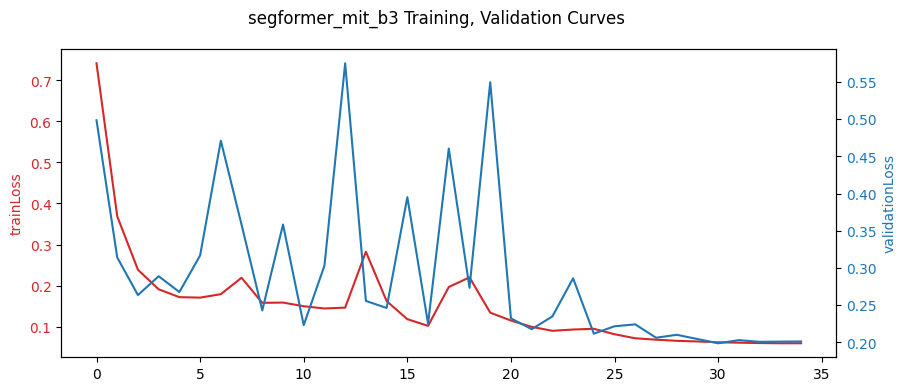

In [19]:
# create optimizer, lr_scheduler and pass to training function
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader),
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer,
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler=scheduler, output_path='weights')

## 4. Evaluate : Evaluate the model on Test Data and visualize results

In [21]:
model.load_state_dict(torch.load(f'weights/{MODEL_NAME}.pt', map_location=device))
#model.load_state_dict(torch.load(f'weights/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")

100%|██████████| 43/43 [00:03<00:00, 13.62it/s]


Model has 0.7777293295027272 mean IoU in test set


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.088313684..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.037333295..1.0].


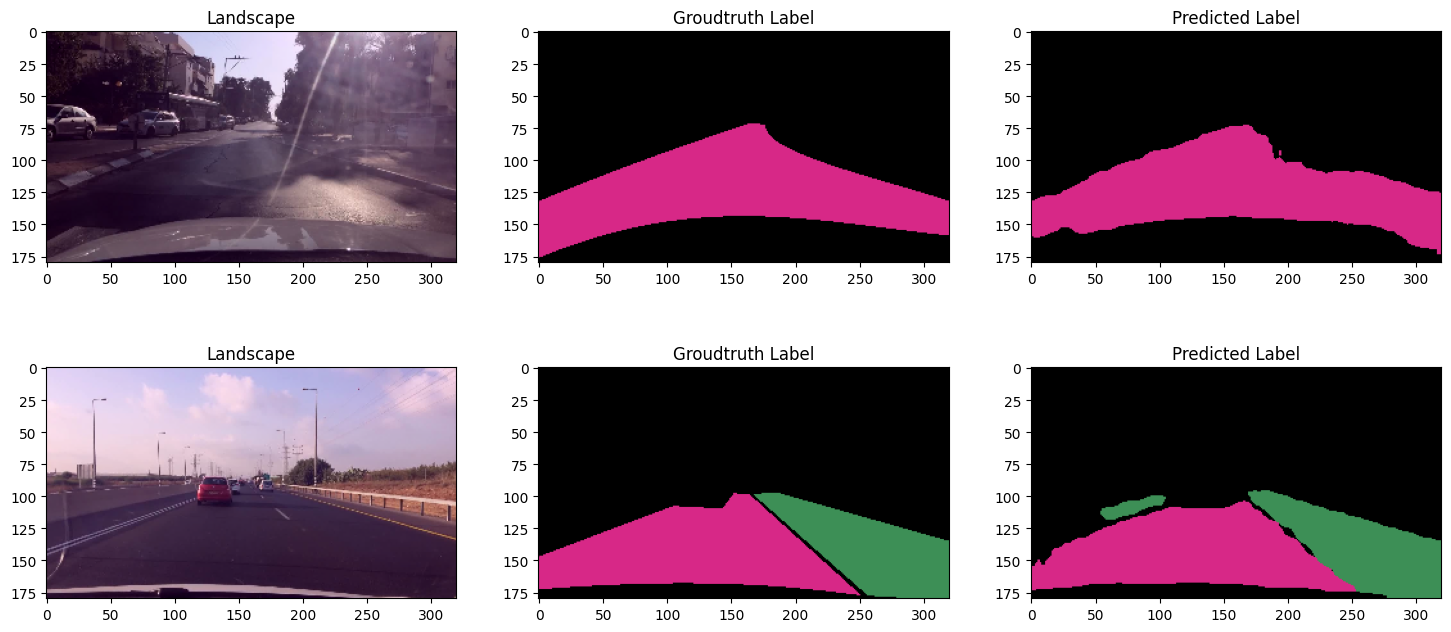

In [28]:
from utils import visualize_predictions
num_test_samples = 2
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_set, axes, device, numTestSamples=num_test_samples, id_to_color =train_id_to_color)

## Test on sample video
If you want to test it on a real video, you can try:

```python
from utils import predict_video
predict_video(model, model_name, input_video_path, output_dir,
            target_width, target_height, device)
```

In out case, we'll have several videos we can try our model on:
* Highway (KITTI)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/highway_1241_376.avi`
* Residential (KITTI)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/residential_1242_375.avi`
* Campus (KITTI)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/campus_1224_370.avi`
* Stuttgart (Cityscapes)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/stuttgart_1024_512.avi`


In [23]:
# !wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/highway_1241_376.avi

In [34]:
from utils import predict_video
predict_video(model, "SegFormer35epochs", "videos/highway_1241_376.avi", "videos", 1241, 376, "cuda")

  0%|          | 0/1170 [00:00<?, ?it/s]

100%|██████████| 1170/1170 [01:52<00:00, 10.36it/s]


In [35]:
#!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/stuttgart_1024_512.avi
predict_video(model, "SegFormer35epochs", "videos/stuttgart_1024_512.avi", "videos", 1024, 512, "cuda")

100%|██████████| 599/599 [01:07<00:00,  8.87it/s]


In [36]:
#!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/campus_1224_370.avi
predict_video(model, "SegFormer35epochs", "videos/campus_1224_370.avi", "videos", 1224, 370, "cuda")

100%|██████████| 110/110 [00:12<00:00,  8.90it/s]


In [37]:
#!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/residential_1242_375.avi
predict_video(model, "SegFormer35epochs", "videos/residential_1242_375.avi", "videos", 1242, 375, "cuda")

100%|██████████| 125/125 [00:13<00:00,  8.97it/s]
